Cox's proportional hazards model
--------------

### Introduction

Cox's proportional hazards (CoxPH) model [[1]](#refer-1) is widely used in medical research and other fields to identify risk factors associated with an outcome of interest, and to estimate how these risk factors affect the time to the outcome while controlling for other variables. Which also offer great flexibility due to its semi-parametric nature.

The CoxPH model specifies the hazard rate $\lambda(t)=\underset{h\to 0}{\lim}\frac{P(T\leq t+h)}{P(T>t)}$ for the survival time $T$ associated with a $p$-vector of possibly time-varying covariates $\mathbf{Z}(\cdot)$, and taking the form 
$$\lambda(t\mid \mathbf{Z})=\lambda_0(t)\exp\{\boldsymbol{\beta}^{\prime}\mathbf{Z}(t)\},$$
where $\boldsymbol{\beta}$ is $p$-vector of regression parameters and $\lambda_0(\cdot)$ is baseline hazard function. In CoxPH model, $\exp(\beta_i)$ is the hazard ratios (HR) of the $i$ th covariate. If $\beta_i>0$ or equivalently $\text{HR}_i >1$, the event hazard increases as the value of the $i$ th covariate increases, and the length of survival decreases. 

For many reasons not all survival time are fully observed, we only consider the right-censoring situation here and let $C$ be the censoring time. Denote the observed time by $X=\min\{T,C\}$ and the censoring indicator by $\delta=I(T\leq C)$. Define the observed-failure counting process $N(t)=I(X\leq t,\delta=1)$ which registers whether an uncensored failure has occurred by time $t$, and the corresponding at-risk indicator $Y(t)=I(X\geq t)$. Without loss of generality, denote 1 as the terminal time of observation and there are $n$ independent data $\{(X_i,\delta_i,\mathbf{Z}_i): i=1,2,\cdots,n\}$.

The negative log partial likelihood function of proportional hazards model is
$$L_2(\boldsymbol{\beta})=-\sum_{i=1}^{n}\int_0^1 \boldsymbol{\beta}^{\prime}\mathbf{Z}_i - \log \left(\sum_{j=1}^n Y_j(t)\exp(\boldsymbol{\beta}^{\prime}\mathbf{Z}_j)\right) \mathrm{d} N_i(t).$$
And the standard Cox model parameter estimation is done by minimizing the likelihood function.


### Sparse CoxPH model

In a high dimensional setting, there is usual a sparse assumption. We can estimate $\boldsymbol{\beta}$ by minimizing the negative log partial likelihood function under sparsity constraint:
$$\arg\min_{\beta \in R^p}L_2(\beta) , s.t.  || \beta ||_0 \leq s.$$

The dataset is generated from ``abess`` library [[2]](#refer-2), and the dataset with 200 subjects where each subject have ten covariates in which two covariates are effective. Then, we visualize the Kaplan-Meier survival curve of 200 subjects.

censoring rate:0.31499999999999995


<AxesSubplot: xlabel='timeline'>

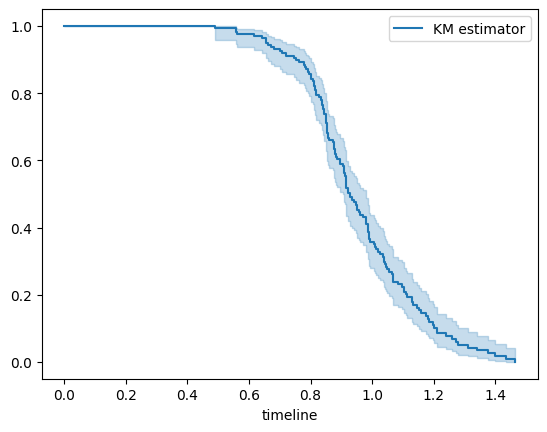

In [6]:
import numpy as np
from abess.datasets import make_glm_data
from lifelines import KaplanMeierFitter

# generate data 
np.random.seed(319)
n, p, k = 200, 10, 2
beta = np.zeros(p)
beta[np.linspace(0, p - 1, k, dtype=int)] = [1 for _ in range(k)]
data = make_glm_data(n, p, k, family="cox", c = 3, coef_=beta)

# survival probability
kmf = KaplanMeierFitter()
kmf.fit(data.y[:,0], data.y[:,1], label="KM estimator", alpha=0.05)
kmf.plot()

Here is Python code for solving the sparse CoxPH model. This can be done rather directly by implementing the objective function of CoxPH model and feed it into `ScopeSolver`.  

In [7]:
import jax.numpy as jnp
from scope import ScopeSolver

def phazard_objective(params):
    Xbeta = jnp.matmul(data.x, params)
    logsum = jnp.zeros_like(Xbeta)
    for i in range(0,n):
        logsum = logsum.at[i].set(jnp.log(jnp.dot(data.y[:,0] >= data.y[:,0][i], jnp.exp(Xbeta))))
    return jnp.dot(data.y[:,1],logsum)/n-jnp.dot(data.y[:,1], Xbeta)/n

solver = ScopeSolver(p, k)
solver.solve(phazard_objective, jit=True)

print("Estimated parameter:", solver.get_result()["params"])
print("True parameter:", data.coef_)

Estimated parameter: [0.83861066 0.         0.         0.         0.         0.
 0.         0.         0.         0.92579964]
True parameter: [1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


From the estimation, the real variables are selected correctly and the estimated parameters are close to the real values. 

### Comparison: sparse & dense models

The following will show a comparison of the fitting results of the CoxPH model before and after variable selection.

In [8]:
from lifelines import CoxPHFitter
import pandas as pd

# save the data as data.frame
data_df = pd.DataFrame(np.hstack((data.x,data.y)))
data_df.rename(columns={p: "time", p+1: "event"}, inplace=True)
data_df = data_df.astype({"event": int})                   # all variables

# model fit with all variables
cph = CoxPHFitter()
cph.fit(data_df, duration_col='time', event_col='event')
cph.print_summary()

/Users/zhujin/miniforge3/envs/convex-solver/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1266: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  self.params_ = pd.Series(params_, index=pd.Index(X.columns, name="covariate"), name="coef")


<lifelines.CoxPHFitter: fitted with 200 total observations, 63 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 200
number of events observed = 137
   partial log-likelihood = -494.67
         time fit was run = 2023-06-05 14:36:34 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
0           0.84       2.33       0.12             0.61             1.08                 1.84                 2.94
1          -0.13       0.88       0.09            -0.31             0.05                 0.73                 1.05
2          -0.02       0.98       0.09            -0.20             0.17                 0.82                 1.18
3           0.07       1.07       0.10            -0.12             0.26                 0.89                 1.29
4          -0.02       0.98       0.09            -0.19             0.16                 0.83                 1.17
5          -0.11       0.89       0.10            -0.31             0.09                 0.73                 1.09
6          -0.04       0.96       0.10            -0.25             0.16                 0.78                 1.17
7           0.05       1.05       0.11            -0.17             0.26                 0.85                 1.29
8           0.05       1.05       0.09            -0.12             0.22                 0.89                 1.24
9           1.00       2.72       0.12             0.76             1.24                 2.13                 3.47

            cmp to     z      p   -log2(p)
covariate                                 
0             0.00  7.04 <0.005      38.97
1             0.00 -1.41   0.16       2.67
2             0.00 -0.19   0.85       0.24
3             0.00  0.71   0.48       1.06
4             0.00 -0.19   0.85       0.23
5             0.00 -1.11   0.27       1.90
6             0.00 -0.41   0.68       0.55
7             0.00  0.43   0.67       0.58
8             0.00  0.57   0.57       0.81
9             0.00  8.07 <0.005      50.29
---
Concordance = 0.74
Partial AIC = 1009.34
log-likelihood ratio test = 111.27 on 10 df
-log2(p) of ll-ratio test = 61.55

From the summary table, only true variables with p-values less than 0.05, while the regression coefficients of other variables are around 0 with HR around 1.

In [9]:
# data preparation
zeroindex = np.where(solver.get_result()["params"]==0)
data_df_selected = data_df.drop(columns=zeroindex[0])     # selected variables

# model fit with selected variables
cph_selected = CoxPHFitter()
cph_selected.fit(data_df_selected, duration_col='time', event_col='event')
cph_selected.print_summary()

/Users/zhujin/miniforge3/envs/convex-solver/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1266: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  self.params_ = pd.Series(params_, index=pd.Index(X.columns, name="covariate"), name="coef")


<lifelines.CoxPHFitter: fitted with 200 total observations, 63 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 200
number of events observed = 137
   partial log-likelihood = -497.23
         time fit was run = 2023-06-05 14:36:34 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
0           0.84       2.31       0.12             0.61             1.07                 1.84                 2.91
9           0.93       2.52       0.11             0.71             1.14                 2.03                 3.14

            cmp to    z      p   -log2(p)
covariate                                
0             0.00 7.21 <0.005      40.71
9             0.00 8.32 <0.005      53.35
---
Concordance = 0.74
Partial AIC = 998.46
log-likelihood ratio test = 106.16 on 2 df
-log2(p) of ll-ratio test = 76.58

All selected variables have significant regression coefficients. The concordance score (also known as the c-index) of the fit, which is a generalization of the ROC AUC to survival data. The concordance scores before and after variable selection are close. Thus, variable selection simplifies the model by selecting the true variables.	

Finally, we compared the more parsimonious survival model and the model with all variables. 

<AxesSubplot: xlabel='HR (95% CI)'>

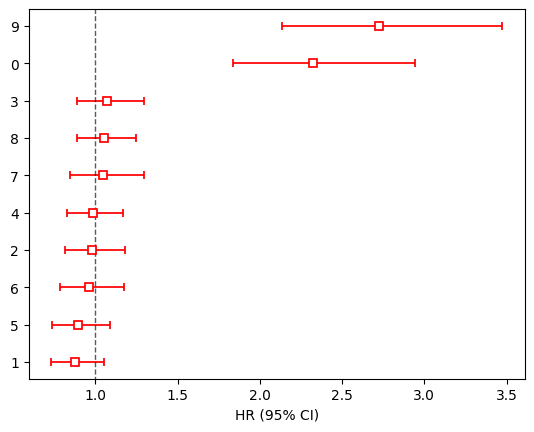

In [10]:
cph.plot(hazard_ratios=True, ecolor='red', c='red') 

<AxesSubplot: xlabel='HR (95% CI)'>

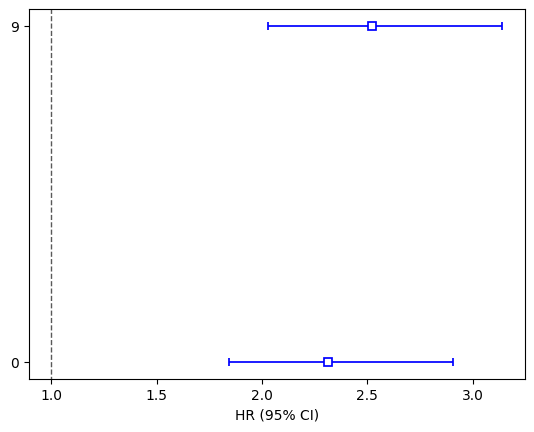

In [11]:
cph_selected.plot(hazard_ratios=True, ecolor='blue', c='blue') 

### Reference

<div id="refer-1"></div>

- [1] Cox, D.R. (1972), Regression Models and Life-Tables. Journal of the Royal Statistical Society: Series B (Methodological), 34: 187-202. https://doi.org/10.1111/j.2517-6161.1972.tb00899.x

<div id="refer-2"></div>

- [2] Zhu, J., Wang, X., Hu, L., Huang, J., Jiang, K., Zhang, Y., ... & Zhu, J. (2022). abess: A fast best-subset selection library in python and r. Journal of Machine Learning Research, 23(202), 1-7.